In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
import os
import sys


import olga.load_model as load_model
import olga.generation_probability as pgen
import olga.sequence_generation as seq_gen


from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



In [2]:
sys.path.append("..")
from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset

[2024-07-15 16:16:52,923] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [4]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [5]:
from epitopes.utilites import balance_majority, balance_minority, process_types, add_spaces

In [6]:
from my_model import save_model, load_model_

In [7]:
vdjdb = pd.read_csv('../data/vdjdb_full_upd.txt', sep='\t', low_memory=False)
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CAVQDLGTSGSRLTF,TRAV20*01,NaN,CASSARSGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,TK3,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLGTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSARSGELFF"", ""cdr3_old"": ""CASSARSG...",1
1,CAVQDLGTSGSRLTF,TRAV20*01,NaN,CASSARSGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,TK6,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLGTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSARSGELFF"", ""cdr3_old"": ""CASSARSG...",1
2,CAVQDLQTSGSRLTF,TRAV20*01,NaN,CASSAPTGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,CS1,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLQTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSAPTGELFF"", ""cdr3_old"": ""CASSAPTG...",1
3,CAVQSLETSGSRLTF,TRAV20*01,NaN,CASSARTGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,MW1,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQSLETSGSRLTF"", ""cdr3_old"": ""CAVQS...","{""cdr3"": ""CASSARTGELFF"", ""cdr3_old"": ""CASSARTG...",1
4,NaN,NaN,NaN,CASSPRRYNEQFF,TRBV9*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*35:08,B2M,...,NaN,SB5,NaN,PBMC,HLA-B*35:08,sanger,NaN,NaN,"{""cdr3"": ""CASSPRRYNEQFF"", ""cdr3_old"": ""CASSPRR...",1


In [8]:
vdjdb.shape

(68306, 34)

In [9]:
vdjb_short = vdjdb[['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 
       'j.beta', 'antigen.epitope', 'antigen.species']]


# vdjb_short = vdjb_short[vdjb_short['antigen.epitope'] != 'KLGGALQAK']
vdjb_short.shape

(68306, 8)

In [10]:
vdjb_short_a = vdjdb[['cdr3.alpha', 'v.alpha', 'j.alpha', 'antigen.epitope', 'antigen.species']]
vdjb_short_b = vdjdb[['cdr3.beta', 'v.beta', 'j.beta', 'antigen.epitope', 'antigen.species']]


In [11]:
vdjb_short_a.isna().sum()

cdr3.alpha         25909
v.alpha            25946
j.alpha            27010
antigen.epitope        0
antigen.species        0
dtype: int64

In [12]:
vdjb_short_b.isna().sum()

cdr3.beta          7713
v.beta             7701
j.beta             7851
antigen.epitope       0
antigen.species       0
dtype: int64

In [13]:
vdjb_short_a = vdjb_short_a.dropna()
vdjb_short_b = vdjb_short_b.dropna()

In [14]:
vdjb_short_a = vdjb_short_a.rename(columns = {'cdr3.alpha': 'cdr3aa', 'v.alpha': 'v', 'j.alpha': 'j'})
vdjb_short_b = vdjb_short_b.rename(columns = {'cdr3.beta': 'cdr3aa', 'v.beta': 'v', 'j.beta': 'j'})

In [15]:
vdjb_short_a['v'] = vdjb_short_a['v'].apply(process_types, 'A')
vdjb_short_b['v'] = vdjb_short_b['v'].apply(process_types, 'B')

vdjb_short_a['j'] = vdjb_short_a['j'].apply(process_types, 'A')
vdjb_short_b['j'] = vdjb_short_b['j'].apply(process_types, 'B')

<BarContainer object of 29 artists>

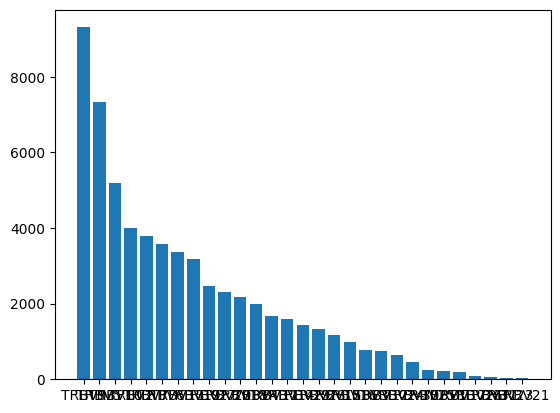

In [16]:
plt.bar(vdjb_short_b.v.unique(), vdjb_short_b.v.value_counts())

In [17]:
alpha_resampl = balance_majority(vdjb_short_a, 'v', min_count=100, max_count=1200)
beta_resampl = balance_majority(vdjb_short_b, 'v', min_count=100, max_count=2000)


In [18]:
alpha_resampl = balance_majority(alpha_resampl, 'j', min_count=100, max_count=1000)
beta_resampl = balance_majority(beta_resampl, 'j', min_count=10, max_count=8000)


<BarContainer object of 32 artists>

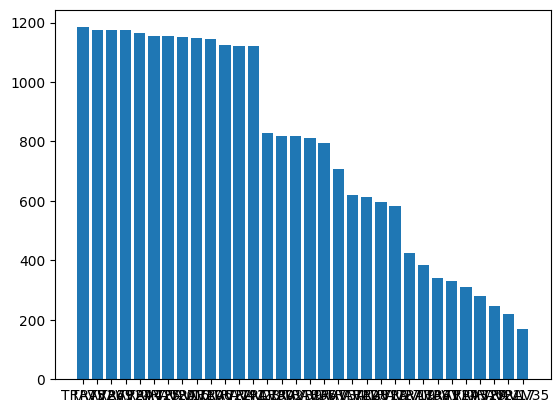

In [19]:
plt.bar(alpha_resampl.v.unique(), alpha_resampl.v.value_counts())

<BarContainer object of 25 artists>

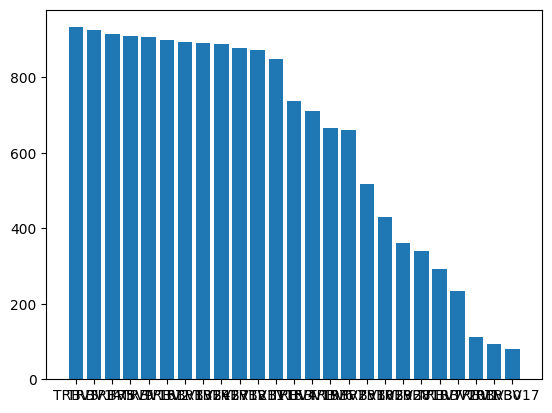

In [20]:
plt.bar(beta_resampl.v.unique(), beta_resampl.v.value_counts())

In [21]:
beta_resampl

,cdr3aa,v,j,antigen.epitope,antigen.species
19406,CASSQASGAGEKRSSYNEQFF,TRBV3,TRBJ2,KLGGALQAK,CMV
38709,CASSQGTISYEQYF,TRBV14,TRBJ2,LLWNGPMAV,YFV
63986,CASSLGPTGELFF,TRBV5,TRBJ2,GILGFVFTL,InfluenzaA
19,CASSARSGELFF,TRBV9,TRBJ2,HPVGEADYFEY,EBV
47835,CASSLAGQGDNYEQYF,TRBV5,TRBJ2,GLCTLVAML,EBV
...,...,...,...,...,...
23857,CASSGGNILDGYTF,TRBV6,TRBJ1,IVTDFSVIK,EBV
20147,CASSFGRGNTEAFF,TRBV27,TRBJ1,KLGGALQAK,CMV
64906,CASSLSKNTEAFF,TRBV12,TRBJ1,TPQDLNTML,HIV-1
32277,CASSPWDSRFYGYTF,TRBV9,TRBJ1,GILGFVFTL,InfluenzaA


In [22]:
alpha_resampl

,cdr3aa,v,j,antigen.epitope,antigen.species
350,CAEILMDSNYQLIW,TRAV5,TRAJ33,DATYQRTRALVR,InfluenzaA
7542,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
7770,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
8066,CAETQDSNYQLIW,TRAV5,TRAJ33,GILGFVFTL,InfluenzaA
8123,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
...,...,...,...,...,...
62311,CAFMMSAGGTSYGKLTF,TRAV38,TRAJ52,GILGFVFTL,InfluenzaA
13352,CADAGGTSYGKLTF,TRAV12,TRAJ52,KLGGALQAK,CMV
8679,CVGGTSYGKLTF,TRAV10,TRAJ52,RAKFKQLL,EBV
16863,CAFIGDAGGTSYGKLTF,TRAV24,TRAJ52,KLGGALQAK,CMV


In [23]:
ab_data = pd.concat([alpha_resampl, beta_resampl], ignore_index=True)

In [24]:
# ab_data = pd.concat([vdjb_short_a, vdjb_short_b], ignore_index=True)

In [25]:
# ab_data['vj'] = ab_data['v'] + ab_data['j']

In [26]:
test_df = ab_data.sample(frac=0.2, random_state=42)
ab_data = ab_data.drop(test_df.index)
ab_data = ab_data.reset_index(drop=True)

In [28]:
ab_v = ab_data[['cdr3aa', 'v']]
ab_j = ab_data[['cdr3aa', 'j']]

In [42]:
ab_j_resampled = balance_minority(ab_j, 'j', max_count=600)
ab_j_resampled = balance_majority(ab_j_resampled, 'j', max_count=800)
ab_j_resampled.to_csv('ab_j_resampled.csv', index=False)

In [ ]:
ab_v_resampled = balance_minority(ab_v, 'v', max_count=600) #or 600
ab_v_resampled = balance_majority(ab_v_resampled, 'v', max_count=800)
ab_v_resampled.to_csv('ab_v_resampled.csv', index=False)

In [112]:
ab_v

,cdr3aa,v
0,CAEILMDSNYQLIW,TRAV5
1,CAETQDSNYQLIW,TRAV5
2,CAETQDSNYQLIW,TRAV5
3,CAETQDSNYQLIW,TRAV5
4,CAETQDSNYQLIW,TRAV5
...,...,...
32700,CASSGGNILDGYTF,TRBV6
32701,CASSFGRGNTEAFF,TRBV27
32702,CASSLSKNTEAFF,TRBV12
32703,CASSPWDSRFYGYTF,TRBV9


In [29]:
ab_v_resampled = pd.read_csv('ab_v_resampled.csv')
ab_j_resampled = pd.read_csv('ab_j_resampled.csv')

<BarContainer object of 57 artists>

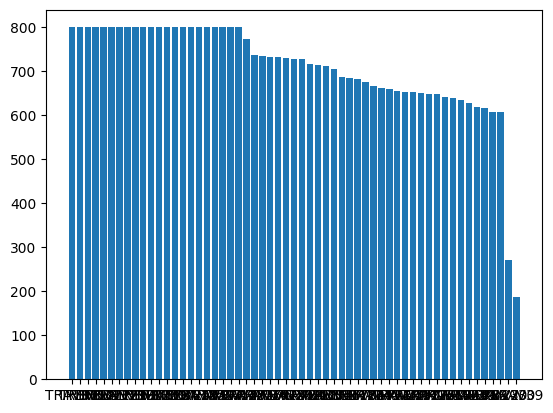

In [30]:
plt.bar(ab_v_resampled.v.unique(), ab_v_resampled.v.value_counts())

In [31]:
v_resampled = ab_v_resampled.copy()

In [32]:
test_df_v = test_df[['cdr3aa', 'v']]
test_df_j = test_df[['cdr3aa', 'j']]

In [30]:
v_uniq = set(v_resampled.v.unique())
v_test_uniq = set(test_df_v.v.unique())

In [31]:
if not v_test_uniq.issubset(v_uniq):
    print('ADD to train df')
    diff = v_test_uniq.difference(v_uniq)
    for i in diff:
        v_resampled.loc[len(v_resampled.index)] = [v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i]
        print(v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i)
        

## V genes

In [82]:
#from sklearn.preprocessing import LabelEncoder
v_resampled = ab_v_resampled.copy()
v_resampled['cdr3aa'] = v_resampled['cdr3aa'].apply(add_spaces)
test_df_v['cdr3aa'] = test_df_v['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(v_resampled['v'])
v_resampled['v'] = l_enc.transform(v_resampled['v'])
test_df_v['v'] = l_enc.transform(test_df_v['v'])


/scratch/ipykernel_1686152/634807742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v['cdr3aa'] = test_df_v['cdr3aa'].apply(add_spaces)
/scratch/ipykernel_1686152/634807742.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v['v'] = l_enc.transform(test_df_v['v'])


In [31]:
test_df_v = test_df_v.reset_index(drop=True)
v_ans = test_df_v.v
test_df_v = test_df_v.drop(columns=['v'])

In [32]:
N_LABELS = v_resampled['v'].nunique()

In [145]:
V_model = CustomModel(n_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([57, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([57]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [146]:
input_ids, attention_masks, labels = V_model.tokenize(v_resampled['cdr3aa'], v_resampled['v'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [147]:
train_dataset, val_dataset = V_model.split_data(input_ids, attention_masks, labels)

32,341 training samples
8,086 validation samples


In [148]:
V_model.fit(train_dataset, val_dataset, epochs=12)


======== Epoch 1 / 12 ========
Training...

  Average training loss: 1.99
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.69
  Validation took: 0:00:05

======== Epoch 2 / 12 ========
Training...

  Average training loss: 1.58
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.57
  Validation took: 0:00:05

======== Epoch 3 / 12 ========
Training...

  Average training loss: 1.40
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.50
  Validation took: 0:00:05

======== Epoch 4 / 12 ========
Training...

  Average training loss: 1.23
  Training epcoh took: 0:01:32

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.48
  Validation took: 0:00:06

======== Epoch 5 / 12 ========
Training...

  Average training loss: 1.07
  Training epcoh took: 0:01:34

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.46
  Validation took: 0:00:05

======== Epoch

In [61]:
V_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.990601,1.679604,0.501729,0:01:28,0:00:06
2,1.571856,1.572768,0.525074,0:01:31,0:00:05
3,1.390334,1.512168,0.550766,0:01:33,0:00:05
4,1.229433,1.463096,0.574481,0:01:33,0:00:05
5,1.065428,1.461156,0.585845,0:01:34,0:00:05
6,0.908347,1.475862,0.597579,0:01:33,0:00:05
7,0.771271,1.510800,0.607831,0:01:33,0:00:05
8,0.639717,1.581831,0.608572,0:01:33,0:00:05
9,0.529775,1.614445,0.615613,0:01:33,0:00:05


In [67]:
v_pred_labels = V_model.predict(test_df_v['cdr3aa'])
f1_sc_v = f1_score(v_ans, v_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_v)
# best one

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.60528


In [149]:
v_pred_labels = V_model.predict(test_df_v['cdr3aa'])
f1_sc_v = f1_score(v_ans, v_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_v)
# best one

Total f1_score: 0.56462


In [88]:
v_pred_labels[-5]

37

## J genes

In [83]:
#from sklearn.preprocessing import LabelEncoder
j_resampled = ab_j_resampled.copy()
j_resampled['cdr3aa'] = j_resampled['cdr3aa'].apply(add_spaces)
test_df_j['cdr3aa'] = test_df_j['cdr3aa'].apply(add_spaces)

l_enc_j = LabelEncoder()
l_enc_j.fit(j_resampled['j'])
j_resampled['j'] = l_enc_j.transform(j_resampled['j'])
test_df_j['j'] = l_enc_j.transform(test_df_j['j'])


/scratch/ipykernel_1686152/1030260844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_j['cdr3aa'] = test_df_j['cdr3aa'].apply(add_spaces)
/scratch/ipykernel_1686152/1030260844.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_j['j'] = l_enc_j.transform(test_df_j['j'])


In [65]:
test_df_j = test_df_j.reset_index(drop=True)
j_ans = test_df_j.j
test_df_j = test_df_j.drop(columns=['j'])

In [35]:
N_LABELS_j = j_resampled['j'].nunique()

In [102]:
J_model = CustomModel(n_labels=N_LABELS_j)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([49, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([49]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
input_ids, attention_masks, labels = J_model.tokenize(j_resampled['cdr3aa'], j_resampled['j'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [104]:
train_dataset, val_dataset = J_model.split_data(input_ids, attention_masks, labels)

29,400 training samples
7,351 validation samples


In [105]:
J_model.fit(train_dataset, val_dataset, epochs=8)


======== Epoch 1 / 8 ========
Training...


KeyboardInterrupt: 

In [153]:
J_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.684346,0.437694,0.815591,0:01:28,0:00:05
2,0.406563,0.381576,0.833468,0:01:28,0:00:05
3,0.364660,0.370535,0.840591,0:01:30,0:00:05
4,0.330825,0.366671,0.845161,0:01:29,0:00:05
5,0.297589,0.364998,0.851210,0:01:28,0:00:05
6,0.264524,0.359039,0.858602,0:01:28,0:00:05
7,0.232526,0.374885,0.856048,0:01:28,0:00:05
8,0.204083,0.379043,0.861290,0:01:28,0:00:05


In [82]:
j_pred_labels = J_model.predict(test_df_j['cdr3aa'])
f1_sc_j = f1_score(j_ans, j_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_j)
# saved (maybe)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.85316


In [150]:
# save_model(J_model, './models/J_model.pth')
# save_model(V_model, './models/V_model.pth')

## Use model

In [36]:
N_LABELS_v = ab_v_resampled['v'].nunique()
N_LABELS_j = ab_j_resampled['j'].nunique()

In [37]:
J_model = load_model_('./models/J_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_j)
V_model = load_model_('./models/V_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_v)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([49, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([49]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([57, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([57]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be ab

In [53]:
# J_model = load_model_('../models_ft/TCR_bert_j_genes.pth', mod_type='TCR-bert', num_labels=N_LABELS_j)
# V_model = load_model_('../models_ft/TCR_bert_v_genes_finetuned.pth', mod_type='TCR-bert', num_labels=N_LABELS_v)

In [38]:
test_df['cdr3aa'] = test_df['cdr3aa'].apply(add_spaces)

In [39]:
j_resampled = ab_j_resampled.copy()
l_enc_j = LabelEncoder()
l_enc_j.fit(j_resampled['j'])

j_ans =  l_enc_j.transform(test_df['j'])



In [40]:
J_model.maximun_len=25

In [41]:
J_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [42]:
j_pred_labels = J_model.predict(test_df['cdr3aa'])
f1_sc_j = f1_score(j_ans, j_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_j)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.85326


In [43]:
v_resampled = ab_v_resampled.copy()

In [44]:
l_enc_v = LabelEncoder()
l_enc_v.fit(v_resampled['v'])

v_ans =  l_enc_v.transform(test_df['v'])



In [45]:
V_model.maximun_len=25

In [46]:
V_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [47]:
v_pred_labels = V_model.predict(test_df['cdr3aa'])
f1_sc_v = f1_score(v_ans, v_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_v)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.56462


# KNN

In [51]:
# create df with emb

In [33]:
N_LABELS_v = ab_v_resampled['v'].nunique()
N_LABELS_j = ab_j_resampled['j'].nunique()

In [34]:
J_model = load_model_('./models/J_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_j)
V_model = load_model_('./models/V_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_v)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([49, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([49]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([57, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([57]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be ab

In [61]:
# test_df_j['cdr3aa'] = test_df_j['cdr3aa'].apply(add_spaces)

In [35]:
j_resampled = ab_j_resampled.copy()
j_resampled['cdr3aa'] = j_resampled['cdr3aa'].apply(add_spaces)

l_enc_j = LabelEncoder()
l_enc_j.fit(j_resampled['j'])
j_resampled['j'] = l_enc_j.transform(j_resampled['j'])


In [37]:
test_df_j

,cdr3aa,j
3719,CIVRAGNQFYF,TRAJ49
36535,CAISTGDSNQPQHF,TRBJ1
15981,CAFLGGANNLFF,TRAJ36
11810,CAMEGAGSGAGSYQLTF,TRAJ28
15278,CAVSGMDSSYKLIF,TRAJ12
...,...,...
13177,CIAPETSYDKVIF,TRAJ50
14453,CAFPEIQGAQKLVF,TRAJ54
6666,CAGAYINNAGNMLTF,TRAJ39
13365,CAATETSYDKVIF,TRAJ50


In [38]:
from knn_setup import create_df_embs, train_clf, get_nearest_neighbours

In [39]:
# df_j_emb = create_df_embs(J_model, j_resampled)
df_j_emb = pd.read_csv('df_j_emb.csv', index_col=0)
df_j_emb.head()

,cdr3aa,j,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,C A E I G S R G A T N K L I F,15,-0.426132,-0.562251,-0.421288,-0.012767,0.374520,0.075270,-0.277857,-0.002976,...,0.538392,-0.249596,0.208609,-0.489767,-0.186424,-0.347575,-0.361532,-0.106374,0.273706,0.516299
1,C A E N P S S G N T P L V F,15,0.121433,-0.587607,-0.084230,0.113568,0.548742,0.292085,-0.258519,-0.094095,...,0.084303,-0.473885,0.114052,-0.335171,-0.014055,-0.286429,-0.583063,-0.191767,0.436899,0.439767
2,C A E R L S G N T P L V F,15,0.279291,-0.326250,-0.179677,0.129202,0.607556,0.247104,-0.100568,-0.087923,...,0.104003,-0.377705,0.034168,-0.315025,0.002262,-0.044136,-0.538276,-0.173648,0.004605,0.531316
3,C A E S P N S G N T P L V F,15,0.158646,-0.601607,-0.204293,0.211412,0.618507,0.218417,-0.096211,-0.164287,...,0.051501,-0.268463,0.157040,-0.373951,-0.142209,-0.224149,-0.490449,-0.317187,0.300066,0.523704
4,C A E S I L E G N T P L V F,15,0.160641,-0.625449,-0.353023,0.155890,0.615850,0.336603,-0.141167,-0.166435,...,0.029298,-0.459723,-0.205698,-0.410837,-0.282631,-0.142199,-0.432674,-0.319380,0.382156,0.428052


In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 36779 samples in 0.008s...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efb096d7160>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[t-SNE] Computed neighbors for 36779 samples in 4.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36779
[t-SNE] Computed conditional probabilities for sample 2000 / 36779
[t-SNE] Computed conditional probabilities for sample 3000 / 36779
[t-SNE] Computed conditional probabilities for sample 4000 / 36779
[t-SNE] Computed conditional probabilities for sample 5000 / 36779
[t-SNE] Computed conditional probabilities for sample 6000 / 36779
[t-SNE] Computed conditional probabilities for sample 7000 / 36779
[t-SNE] Computed conditional probabilities for sample 8000 / 36779
[t-SNE] Computed conditional probabilities for sample 9000 / 36779
[t-SNE] Computed conditional probabilities for sample 10000 / 36779
[t-SNE] Computed conditional probabilities for sample 11000 / 36779
[t-SNE] Computed conditional probabilities for sample 12000 / 36779
[t-SNE] Computed conditional probabilities for sample 13000 / 36779
[t-SNE] Computed conditional probabilities for sample 14000 / 36779

/scratch/ipykernel_2673910/4132079214.py:7: UserWarning: 
The palette list has fewer values (48) than needed (49) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


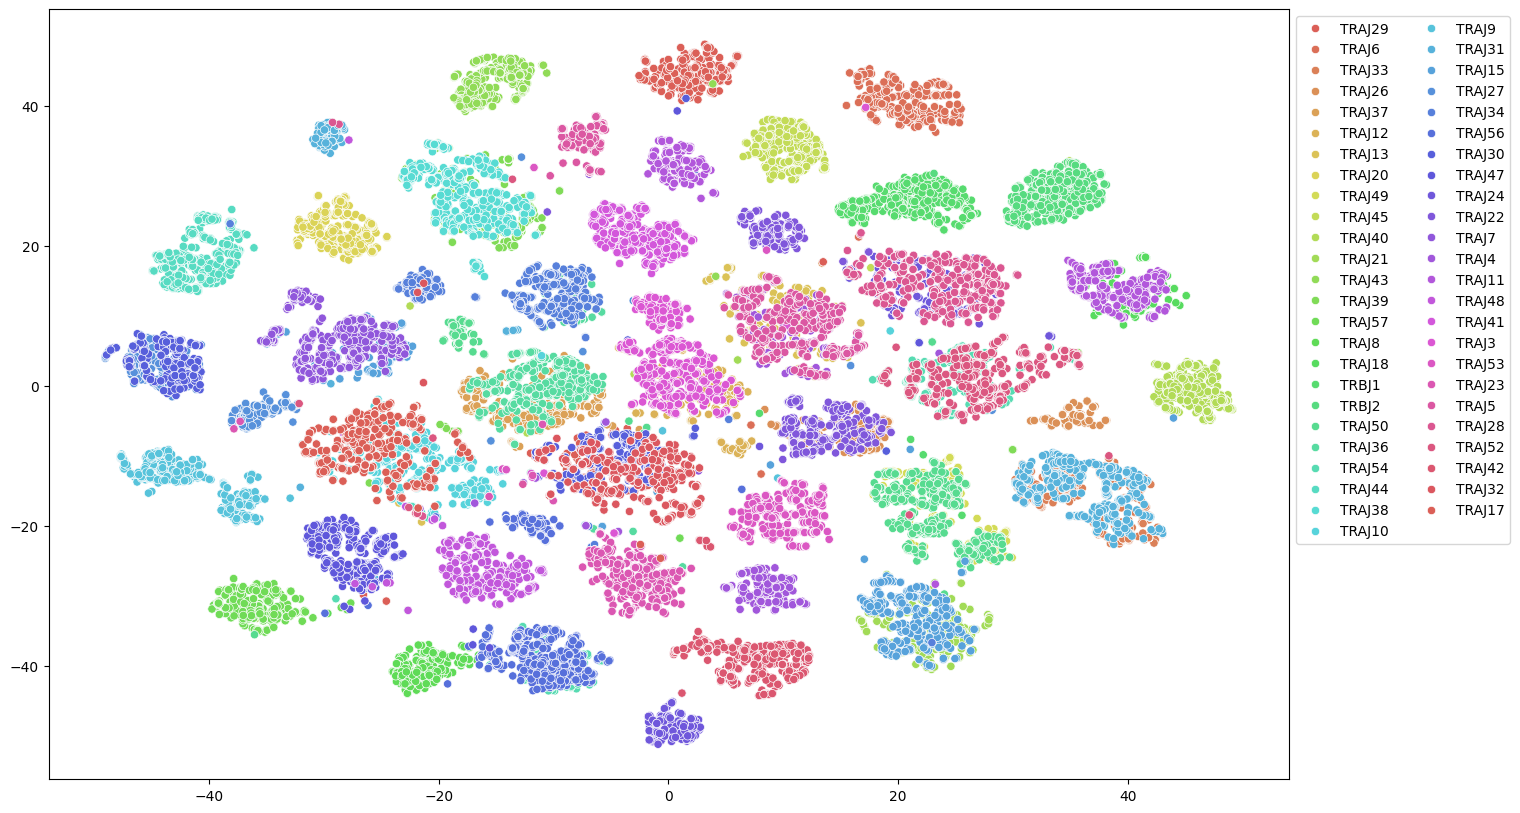

In [36]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(df_j_emb.drop(columns=['cdr3aa', 'j']))

tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc_j.inverse_transform(j_resampled.j),
    palette=sns.color_palette("hls", 48),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)

In [45]:
from sklearn.model_selection import train_test_split
df_j_emb.drop(columns = ['cdr3aa'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df_j_emb.drop(['j'], axis=1), df_j_emb['j'], test_size=0.20, random_state=42)

In [45]:
train_clf(X_train, X_test, y_train, y_test, gene='j', save=True)



Best CV score: 0.878, best CV k: KNeighborsClassifier(n_neighbors=35, weights='distance')
Resulting test score: 0.881

In [42]:
test_df_j

,cdr3aa
3719,C I V R A G N Q F Y F
36535,C A I S T G D S N Q P Q H F
15981,C A F L G G A N N L F F
11810,C A M E G A G S G A G S Y Q L T F
15278,C A V S G M D S S Y K L I F
...,...
13177,C I A P E T S Y D K V I F
14453,C A F P E I Q G A Q K L V F
6666,C A G A Y I N N A G N M L T F
13365,C A A T E T S Y D K V I F


In [48]:
with open('knn_j_model.pkl', 'rb') as file:
    j_knn = pickle.load(file)

In [41]:
j_ans = test_df_j.j
test_df_j.drop(columns=['j'], inplace = True)
test_df_j['cdr3aa'] = test_df_j['cdr3aa'].apply(add_spaces)

/scratch/ipykernel_2971336/157229520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_j.drop(columns=['j'], inplace = True)
/scratch/ipykernel_2971336/157229520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_j['cdr3aa'] = test_df_j['cdr3aa'].apply(add_spaces)


In [75]:
df_j_emb_test.drop(columns=['cdr3aa'], inplace=True)
test_predictions = j_knn.predict(df_j_emb_test)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83cdc155e0>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [79]:
f1_score(test_predictions, j_ans, average='macro')

0.8468812725783317

In [49]:
nn_j = get_nearest_neighbours('./knn_j_model.pkl', J_model, test_df_j.iloc[0].values[0], X_train, y_train, print_info=True)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1a5ada5f70>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3

Query Point: C I V R A G N Q F Y F
Nearest Neighbors: [6035, 6213, 6479, 6020, 6342, 5919, 13526, 6158, 12809, 6200, 6113, 6241, 6042, 12811, 6201, 6170, 13451, 6202, 6210, 13455, 5930, 6283, 5927, 6284, 5970, 6292, 6205, 5931, 6021, 12872, 12937, 13320, 6321, 6309, 6300]
Nearest Labels: [35 35 35 35 35 35 37 35 37 35 35 35 35 37 35 35 37 35 35 37 35 35 35 35
 35 35 35 35 35 37 37 37 35 35 35]
Distances to Nearest Neighbors: [[4.32389947 4.99054102 5.00800232 5.14447578 5.14447578 5.16182824
  5.16845585 5.19892428 5.23230234 5.33744882 5.40767554 5.41432228
  5.45170347 5.45170347 5.47452145 5.48592151 5.4943814  5.52618675
  5.52688178 5.52688178 5.52784298 5.57640067 5.58524105 5.59574084
  5.61282128 5.62927603 5.64976654 5.65000733 5.68188201 5.68345782
  5.68345782 5.68345782 5.70198102 5.70198102 5.70198102]]


In [56]:
l_enc_j.inverse_transform(y_train.loc[nn_j].values)

array(['TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49',
       'TRAJ50', 'TRAJ49', 'TRAJ50', 'TRAJ49', 'TRAJ49', 'TRAJ49',
       'TRAJ49', 'TRAJ50', 'TRAJ49', 'TRAJ49', 'TRAJ50', 'TRAJ49',
       'TRAJ49', 'TRAJ50', 'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49',
       'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ49', 'TRAJ50',
       'TRAJ50', 'TRAJ50', 'TRAJ49', 'TRAJ49', 'TRAJ49'], dtype=object)

In [58]:
j_resampled.loc[nn_j]

,cdr3aa,j
6035,C A V R A G N Q F Y F,35
6213,C A V I A G N Q F Y F,35
6479,C A V R P G N Q F Y F,35
6020,C A S N T G N Q F Y F,35
6342,C A S N T G N Q F Y F,35
5919,C I A G F N N Q F Y F,35
13526,C I G G A G N Q F Y F,37
6158,C A V A F G N Q F Y F,35
12809,C A T G K G N Q F Y F,37
6200,C A V N A G N Q F Y F,35


In [59]:
# import pickle 
# with open('knn_j_model.pkl', 'wb') as file:
#     pickle.dump(j_knn, file)
    
# with open('knn_j_model.pkl', 'rb') as file:
#     j_knn = pickle.load(file)

In [60]:
v_resampled = ab_v_resampled.copy()
v_resampled['cdr3aa'] = v_resampled['cdr3aa'].apply(add_spaces)

l_enc_v = LabelEncoder()
l_enc_v.fit(v_resampled['v'])
v_resampled['v'] = l_enc_v.transform(v_resampled['v'])


In [61]:
test_df_v['v'] = l_enc_v.transform(test_df_v['v'])

/scratch/ipykernel_2971336/333619851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v['v'] = l_enc_v.transform(test_df_v['v'])


In [63]:
# df_v_emb =create_df_embs(V_model, v_resampled)
df_v_emb = pd.read_csv('df_v_emb.csv', index_col=0)
df_v_emb.head()

,cdr3aa,v,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,C A A S S D D R G S T L G R L Y F,22,0.106786,-0.512697,-0.076082,0.203516,0.411284,0.336891,-0.336998,0.088247,...,0.239719,-0.416542,0.096271,0.070174,-0.338266,-0.079271,0.003011,-0.295817,0.310441,0.091735
1,C A A S D T G R R A L T F,22,-0.053867,-0.380920,-0.105906,0.076800,0.480460,0.152093,-0.368739,-0.240869,...,0.274712,0.033949,0.242866,0.349282,-0.491451,0.041307,-0.067962,-0.462887,0.583545,0.041184
2,C A L H S N Y Q L I W,22,0.178190,-0.513390,-0.120137,0.230815,-0.036075,0.052500,-0.238904,-0.604821,...,-0.085029,0.203549,-0.140403,0.189360,0.128752,-0.312984,-0.671885,-0.200153,0.388090,0.180100
3,C A V F S S N T G K L I F,22,0.226485,-0.316371,-0.502283,0.191284,0.562620,0.063594,-0.326593,-0.033437,...,0.242232,-0.324051,0.174396,0.220110,-0.061373,0.232409,-0.398568,-0.361992,0.306920,-0.036186
4,C A A F D S G N T G K L I F,22,0.178506,-0.260318,-0.099152,0.270518,0.345245,0.257018,-0.175052,0.183799,...,0.149175,-0.193483,-0.113744,0.243659,-0.321598,0.092938,-0.269699,-0.200736,0.304403,0.120348


In [ ]:
# v_knn = train_clf(df_v_emb, path='knn_v_model.pkl')

In [64]:
df_v_emb.drop(columns = ['cdr3aa'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df_v_emb.drop(['v'], axis=1), df_v_emb['v'], test_size=0.20, random_state=42)

with open('knn_v_model.pkl', 'rb') as file:
    v_knn = pickle.load(file)# knn = KNeighborsClassifier()




In [148]:
v_knn = train_clf(df_v_emb, path='knn_v_model.pkl')


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83913b25e0>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Best CV score: 0.666, best CV k: KNeighborsClassifier(n_neighbors=40, weights='distance')
Resulting test score: 0.675


In [149]:
# v_knn = grid_search.best_estimator_
# with open('knn_v_model.pkl', 'wb') as file:
#     pickle.dump(v_knn, file)

In [65]:
nn_v = get_nearest_neighbours('./knn_v_model.pkl', V_model, test_df_v.iloc[0].values[0], X_train, y_train, print_info=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo

Query Point: CIVRAGNQFYF
Nearest Neighbors: [39022, 4349, 29451, 39237, 13654, 21535, 8673, 37389, 27711, 12474, 21329, 13764, 20704, 17497, 39485, 39597, 16076, 25750, 17973, 8507, 26719, 37886, 29823, 4840, 5028, 4888, 4994, 5123, 4803, 31406, 31052, 30791, 14771, 21003, 20074, 30955, 39187, 4713, 25313, 20077]
Nearest Labels: [19 35  2 19 29 32 44 11 10 31 32 29  1 28 19 19 12 26 28 44 18 11  2 49
 49 49 49 49 49 15 15  6 37  1 25 15 19 49 26 25]
Distances to Nearest Neighbors: [[11.18192616 11.4225292  11.55357588 11.66584349 11.77838167 11.86714657
  11.90775092 11.95047268 11.95194043 11.98244872 12.00302038 12.0602216
  12.0719683  12.09585207 12.11444807 12.11444807 12.11733908 12.13264372
  12.14030375 12.18656555 12.22530162 12.23059775 12.23242734 12.24403009
  12.24403009 12.24403009 12.24403009 12.24403009 12.24403009 12.24600489
  12.25176713 12.25384496 12.25491579 12.2684947  12.29429364 12.30372188
  12.31896617 12.33214247 12.37209768 12.38140685]]


In [66]:
l_enc_v.inverse_transform(y_train.loc[nn_v].values)

array(['TRAV30', 'TRBV12', 'TRAV12', 'TRAV30', 'TRAV7', 'TRBV1', 'TRBV20',
       'TRAV22', 'TRAV21', 'TRAV9', 'TRBV1', 'TRAV7', 'TRAV10', 'TRAV6',
       'TRAV30', 'TRAV30', 'TRAV23', 'TRAV41', 'TRAV6', 'TRBV20', 'TRAV3',
       'TRAV22', 'TRAV12', 'TRBV29', 'TRBV29', 'TRBV29', 'TRBV29',
       'TRBV29', 'TRBV29', 'TRAV26', 'TRAV26', 'TRAV17', 'TRBV14',
       'TRAV10', 'TRAV4', 'TRAV26', 'TRAV30', 'TRBV29', 'TRAV41', 'TRAV4'],
      dtype=object)

In [67]:
v_resampled.loc[nn_v]

,cdr3aa,v
39022,C H N R L A F,19
4349,C W G N T E A F F,35
29451,C A R S T F,2
39237,C N T G K L I F,19
13654,C S S N T G K L I F,29
21535,C P L E N E A F F,32
8673,C S A T L N W G F F,44
37389,C E N Q G G K L I F,11
27711,S S G N Q F Y F,10
12474,C A L R P A,31


In [38]:
# df_j_emb.to_csv('df_j_emb.csv')
# df_v_emb.to_csv('df_v_emb.csv')